# Objetivos

- Reducir falsos positivos en perfiles con transacciones complejas
- Evitar alertas innecesarias en clientes con comportamiento legítimo pero no convencional.
- nueva varibale.


In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import randint, uniform


from sklearn.metrics import (classification_report, confusion_matrix, 
                            roc_auc_score, precision_recall_curve, 
                            average_precision_score, make_scorer)
from scipy.stats import randint, uniform
from lightgbm import LGBMClassifier, early_stopping

from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from lightgbm import early_stopping


import joblib


In [2]:
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

In [3]:
import warnings
warnings.filterwarnings("ignore")


# PARTE 1. EDA

In [4]:
df = pd.read_csv("feature_engineering_work/dataset_feature_engineering.csv")
df

,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,amt_month,amt_year,amt_month_shopping_net_spend,count_month_shopping_net,first_time_at_merchant,dist_between_client_and_merch,trans_month,trans_day,hour,year,times_shopped_at_merchant,times_shopped_at_merchant_year,times_shopped_at_merchant_month,times_shopped_at_merchant_day
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,4.97,4.97,0.00,0.0,True,78.773821,1,1,0,2019,5,4,2,1
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,107.23,107.23,0.00,0.0,True,30.216618,1,1,0,2019,4,4,1,1
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,220.11,220.11,0.00,0.0,True,108.102912,1,1,0,2019,4,3,1,1
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,45.00,45.00,0.00,0.0,True,95.685115,1,1,0,2019,1,1,1,1
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,41.96,41.96,0.00,0.0,True,77.702395,1,1,0,2019,6,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852389,30560609640617,fraud_Reilly and Sons,health_fitness,43.77,Michael,Olson,M,558 Michael Estates,Luray,MO,63453,40.4931,-91.8912,519,Town planner,1966-02-13,9b1f753c79894c9f4b71f04581835ada,1388534347,39.946837,-91.333331,0,11619.63,72134.23,1014.44,11.0,False,77.032467,12,3,23,2020,6,3,1,1
1852390,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.84,Jose,Vasquez,M,572 Davis Mountains,Lake Jackson,TX,77566,29.0393,-95.4401,28739,Futures trader,1999-12-27,2090647dac2c89a1d86c514c427f5b91,1388534349,29.661049,-96.186633,0,15224.47,87115.43,3942.78,25.0,False,100.023736,12,3,23,2020,5,3,1,1
1852391,6011724471098086,fraud_Rau-Robel,kids_pets,86.88,Ann,Lawson,F,144 Evans Islands Apt. 683,Burbank,WA,99323,46.1966,-118.9017,3684,Musician,1981-11-29,6c5b7c8add471975aa0fec023b2e8408,1388534355,46.658340,-119.715054,0,26233.12,165389.30,2978.91,29.0,False,80.887812,12,3,23,2020,10,7,1,2
1852392,4079773899158,fraud_Breitenberg LLC,travel,7.99,Eric,Preston,M,7020 Doyle Stream Apt. 951,Mesa,ID,83643,44.6255,-116.4493,129,Cartographer,1965-12-15,14392d723bb7737606b2700ac791b7aa,1388534364,44.470525,-117.080888,0,11787.71,90698.65,768.69,17.0,False,53.060882,12,3,23,2020,4,2,2,1


In [5]:
df.describe()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,amt_month,amt_year,amt_month_shopping_net_spend,count_month_shopping_net,dist_between_client_and_merch,trans_month,trans_day,hour,year,times_shopped_at_merchant,times_shopped_at_merchant_year,times_shopped_at_merchant_month,times_shopped_at_merchant_day
count,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06
mean,4.173860e+17,7.006357e+01,4.881326e+04,3.853931e+01,-9.022783e+01,8.864367e+04,1.358674e+09,3.853898e+01,-9.022794e+01,5.210015e-03,4.153689e+03,4.530560e+04,3.762028e+02,4.567241e+00,7.610956e+01,7.152067e+00,2.967456e+00,1.280612e+01,2.019501e+03,5.298079e+00,3.150459e+00,1.389109e+00,1.655442e+00
std,1.309115e+18,1.592540e+02,2.688185e+04,5.071470e+00,1.374789e+01,3.014876e+05,1.819508e+07,5.105604e+00,1.375969e+01,7.199217e-02,3.909005e+03,3.586752e+04,7.253531e+02,4.575502e+00,2.909273e+01,3.424954e+00,2.197983e+00,6.815753e+00,4.999996e-01,3.094345e+00,1.865369e+00,6.722559e-01,9.025901e-01
min,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902742e+01,-1.666716e+02,0.000000e+00,1.000000e+00,1.020000e+00,0.000000e+00,0.000000e+00,2.227351e-02,1.000000e+00,0.000000e+00,0.000000e+00,2.019000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.800429e+14,9.640000e+00,2.623700e+04,3.466890e+01,-9.679800e+01,7.410000e+02,1.343017e+09,3.474012e+01,-9.689944e+01,0.000000e+00,1.344790e+03,1.734142e+04,9.020000e+00,1.000000e+00,5.534198e+01,4.000000e+00,1.000000e+00,7.000000e+00,2.019000e+03,3.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00
50%,3.521417e+15,4.745000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.443000e+03,1.357089e+09,3.936890e+01,-8.744069e+01,0.000000e+00,3.071990e+03,3.743910e+04,7.589000e+01,3.000000e+00,7.824823e+01,7.000000e+00,3.000000e+00,1.400000e+01,2.020000e+03,5.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00
75%,4.642255e+15,8.310000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.374581e+09,4.195626e+01,-8.024511e+01,0.000000e+00,5.738470e+03,6.472088e+04,4.259800e+02,7.000000e+00,9.847204e+01,1.000000e+01,5.000000e+00,1.900000e+01,2.020000e+03,7.000000e+00,4.000000e+00,2.000000e+00,2.000000e+00
max,4.992346e+18,2.894890e+04,9.992100e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.388534e+09,6.751027e+01,-6.695090e+01,1.000000e+00,4.326189e+04,2.190868e+05,1.204718e+04,4.800000e+01,1.518682e+02,1.200000e+01,6.000000e+00,2.300000e+01,2.020000e+03,2.800000e+01,1.700000e+01,9.000000e+00,9.000000e+00


In [6]:
df.columns

Index(['cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender',
       'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job',
       'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud',
       'amt_month', 'amt_year', 'amt_month_shopping_net_spend',
       'count_month_shopping_net', 'first_time_at_merchant',
       'dist_between_client_and_merch', 'trans_month', 'trans_day', 'hour',
       'year', 'times_shopped_at_merchant', 'times_shopped_at_merchant_year',
       'times_shopped_at_merchant_month', 'times_shopped_at_merchant_day'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 35 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   cc_num                           int64  
 1   merchant                         object 
 2   category                         object 
 3   amt                              float64
 4   first                            object 
 5   last                             object 
 6   gender                           object 
 7   street                           object 
 8   city                             object 
 9   state                            object 
 10  zip                              int64  
 11  lat                              float64
 12  long                             float64
 13  city_pop                         int64  
 14  job                              object 
 15  dob                              object 
 16  trans_num                        object 
 17  unix_tim

Distribución de fraudes:
is_fraud
0    0.99479
1    0.00521
Name: proportion, dtype: float64


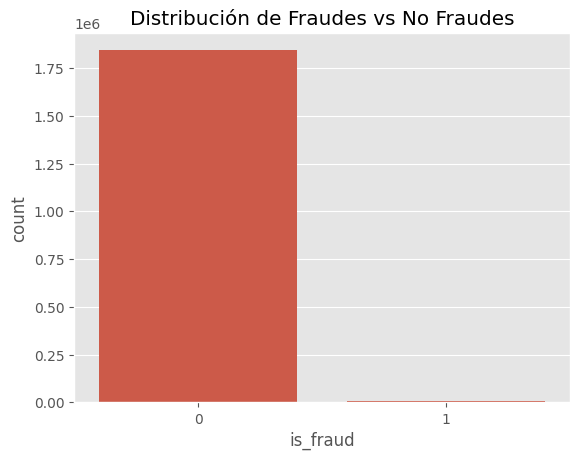

In [8]:
# Distribución
fraud_ratio = df['is_fraud'].value_counts(normalize=True)
print("Distribución de fraudes:")
print(fraud_ratio)

sns.countplot(x='is_fraud', data=df)
plt.title('Distribución de Fraudes vs No Fraudes')
plt.show()


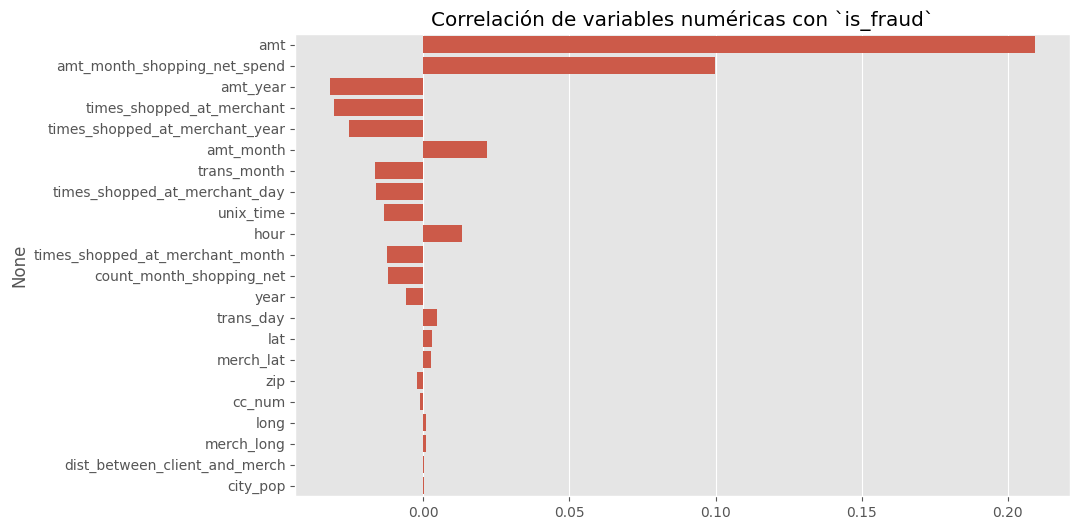

In [9]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).drop(columns=['is_fraud'])
corr = numeric_cols.corrwith(df['is_fraud']).sort_values(key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=corr.values, y=corr.index)
plt.title("Correlación de variables numéricas con `is_fraud`")
plt.show()


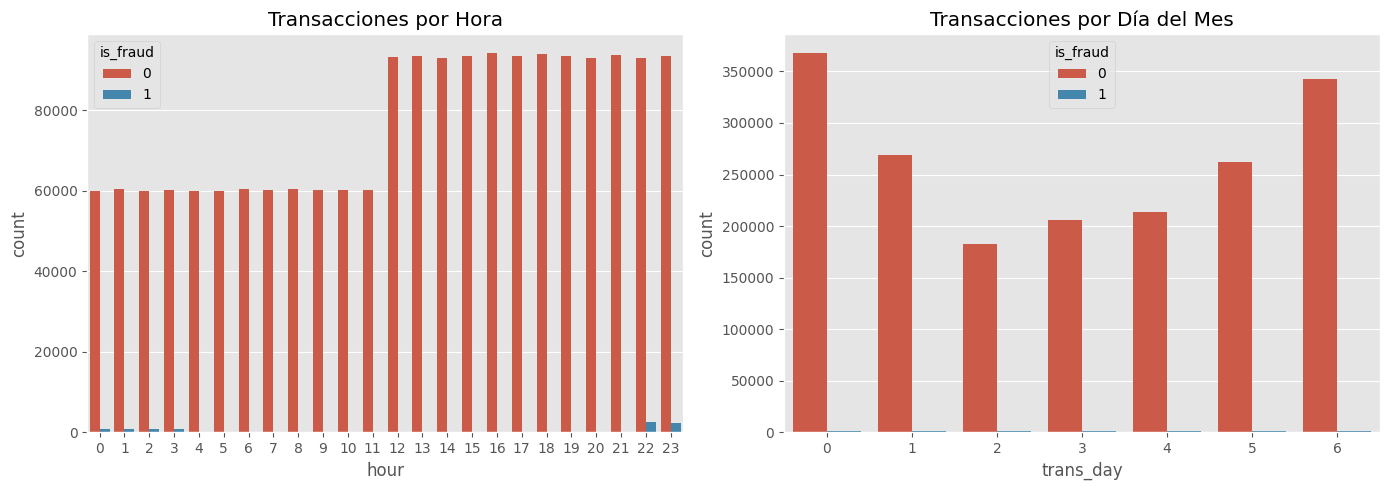

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.countplot(x='hour', hue='is_fraud', data=df, ax=ax[0])
ax[0].set_title('Transacciones por Hora')

sns.countplot(x='trans_day', hue='is_fraud', data=df, ax=ax[1])
ax[1].set_title('Transacciones por Día del Mes')

plt.tight_layout()
plt.show()


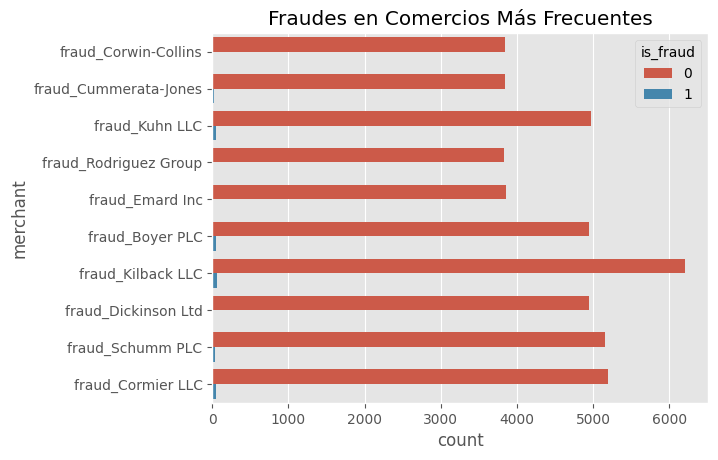

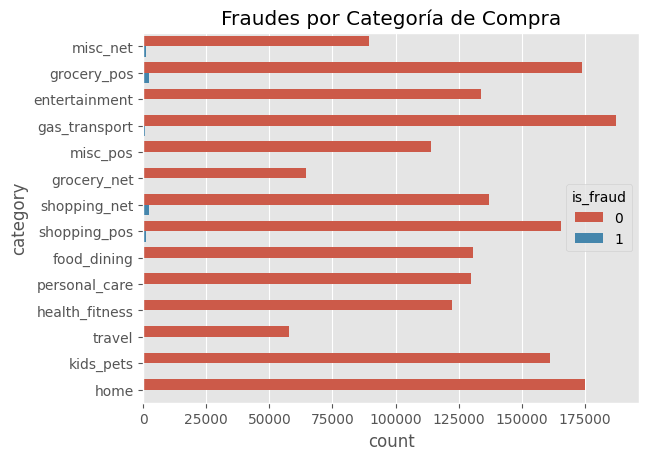

In [11]:
top_merchants = df['merchant'].value_counts().head(10).index
df_top = df[df['merchant'].isin(top_merchants)]

sns.countplot(y='merchant', hue='is_fraud', data=df_top)
plt.title("Fraudes en Comercios Más Frecuentes")
plt.show()

sns.countplot(y='category', hue='is_fraud', data=df)
plt.title("Fraudes por Categoría de Compra")
plt.show()


# Complejidad

## Número de comercios distintos por cliente
Hay clientes que han visitado muchos comercios distintos (¡incluso ~700!). Estos son los perfiles potencialmente “complejos” o “no convencionales”.

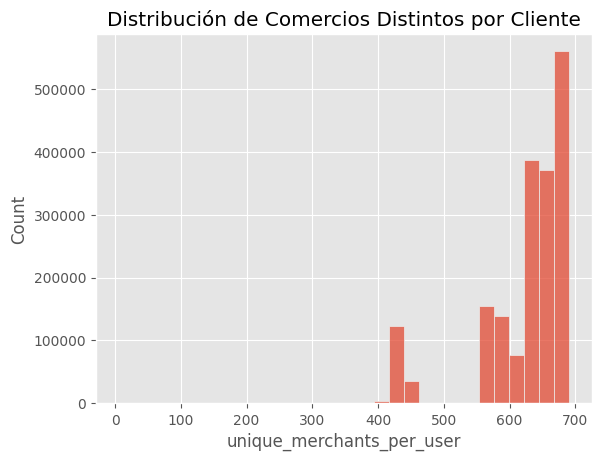

In [12]:
df['unique_merchants_per_user'] = df.groupby('cc_num')['merchant'].transform('nunique')
sns.histplot(df['unique_merchants_per_user'], bins=30)
plt.title("Distribución de Comercios Distintos por Cliente")
plt.show()


## Varianza de monto mensual por cliente
Hay usuarios con varianza muy alta (comportamiento volátil en los montos gastados). Puede ser difícil para modelos tradicionales. Puede llegar a generar falsos positivos si no se modela bien su comportamiento.

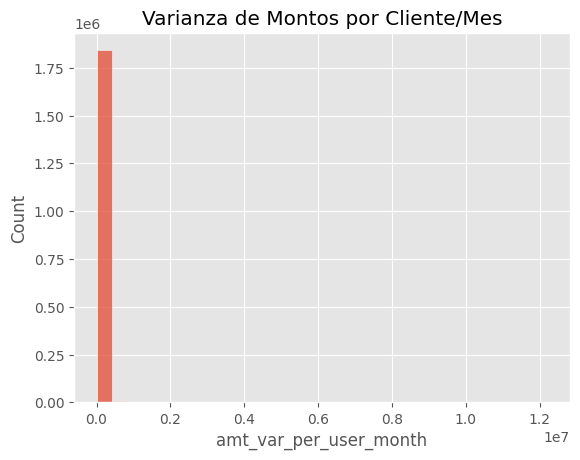

In [13]:
df['amt_var_per_user_month'] = df.groupby(['cc_num','trans_month'])['amt'].transform('var').fillna(0)
sns.histplot(df['amt_var_per_user_month'], bins=30)
plt.title("Varianza de Montos por Cliente/Mes")
plt.show()


## Porcentaje de compras en horario nocturno (ej. 22 a 6 hrs)
Algunos clientes compran mucho de noche. Estos son comportamientos que pueden parecer raros pero pueden ser legítimos.

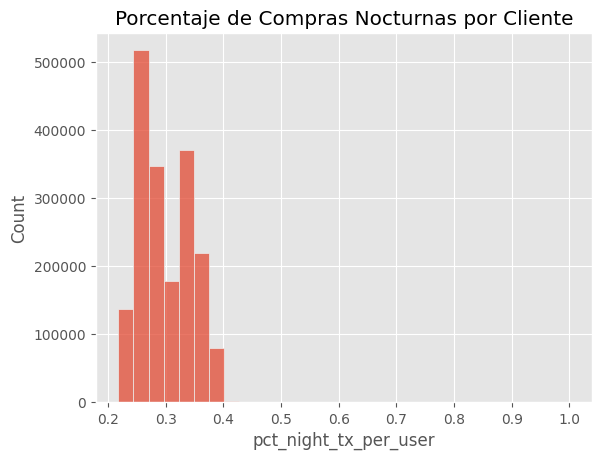

In [14]:
df['night_tx'] = df['hour'].apply(lambda x: 1 if (x >= 22 or x < 6) else 0)
df['pct_night_tx_per_user'] = df.groupby('cc_num')['night_tx'].transform('mean')
sns.histplot(df['pct_night_tx_per_user'], bins=30)
plt.title("Porcentaje de Compras Nocturnas por Cliente")
plt.show()


## Cantidad perfiles complejos

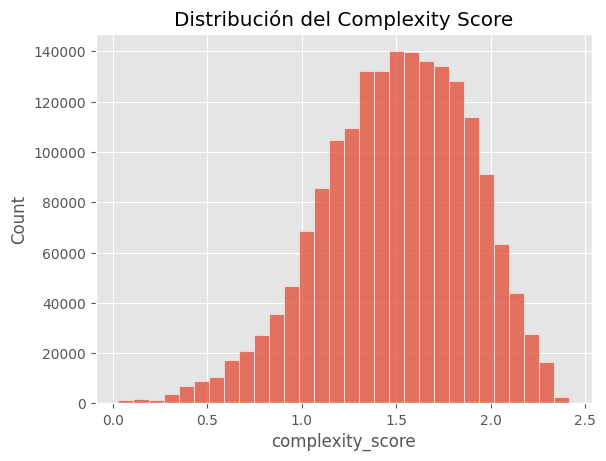

In [15]:
# Normalización por percentil
df['complexity_score'] = (
    df['unique_merchants_per_user'].rank(pct=True) +
    df['amt_var_per_user_month'].rank(pct=True) +
    df['pct_night_tx_per_user'].rank(pct=True)
)
sns.histplot(df['complexity_score'], bins=30)
plt.title("Distribución del Complexity Score")
plt.show()

# PARTE 2. Feature Engineering (Variables de Complejidad)

In [16]:
# -- VARIABLES DE COMPLEJIDAD --

# Número de comercios distintos por cliente
df['unique_merchants_per_user'] = df.groupby('cc_num')['merchant'].transform('nunique')

# Varianza de monto mensual por cliente
df['amt_var_per_user_month'] = df.groupby(['cc_num','trans_month'])['amt'].transform('var').fillna(0)

# Porcentaje de compras nocturnas por cliente
df['night_tx'] = df['hour'].apply(lambda x: 1 if (x >= 22 or x < 6) else 0)
df['pct_night_tx_per_user'] = df.groupby('cc_num')['night_tx'].transform('mean')

# Complexity Score
df['complexity_score'] = (
    df['unique_merchants_per_user'].rank(pct=True) +
    df['amt_var_per_user_month'].rank(pct=True) +
    df['pct_night_tx_per_user'].rank(pct=True)
)

# Marcamos perfiles complejos (top 20%)
complexity_threshold = df['complexity_score'].quantile(0.8)
df['is_complex_profile'] = df['complexity_score'] >= complexity_threshold


# 2. Features temporales avanzadas
df['time_since_last_tx'] = df.groupby('cc_num')['unix_time'].diff().fillna(0)
df['day_of_week'] = pd.to_datetime(df['unix_time'], unit='s').dt.dayofweek

# 3. Interacciones clave
df['dist_amt_interaction'] = df['dist_between_client_and_merch'] * df['amt']
df['night_shopping'] = ((df['hour'] >= 22) | (df['hour'] <= 6)).astype(int) * df['category'].astype('category').cat.codes

# 4. Rolling features
df['rolling_amt_7d'] = df.groupby('cc_num')['amt'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
df['amt_vs_avg'] = df['amt'] / df.groupby('cc_num')['amt'].transform('mean')

df['unusual_location'] = (df['dist_between_client_and_merch'] > 1000).astype(int)


- unique_merchants_per_user: Los defraudadores suelen diversificar comercios rápidamente. Esta variable captura ese patrón.
- amt_var_per_user_month: La variabilidad en montos puede indicar comportamiento anómalo.
- night_tx + pct_night_tx_per_user: Las transacciones nocturnas tienen mayor riesgo de fraude (menos supervisión).
- complexity_score: Combina métricas clave en un indicador unificado usando percentiles para normalizar escalas.
- is_complex_profile: Identifica el 20% superior de perfiles complejos (umbral empírico usado en fraud detection).

Estas variables permiten identificar clientes con comportamientos complejos pero legítimos (por ejemplo, alta diversidad de compras, gasto variable o actividad nocturna frecuente). Al agrupar estas señales en un complexity_score, se marca el 20% superior como is_complex_profile, para que el modelo aprenda a no penalizar perfiles legítimos con patrones atípicos.

- time_since_last_tx: Los fraudes suelen ocurrir en ráfagas (múltiples transacciones en poco tiempo).
- day_of_week: Los fines de semana (días 5-6) tienen mayor riesgo por menor supervisión humana.

Estas variables capturan la dinámica temporal de las transacciones. Por ejemplo, si un cliente realiza muchas transacciones muy seguidas o solo en ciertos días de la semana, eso puede indicar automatismo o fraude. Ayudan a modelar patrones de comportamiento normal vs anómalo.

- dist_amt_interaction: Combina distancia geográfica con monto (ej: $10K en otro país es más sospechoso que $100 local).
- night_shopping: Interacción entre hora y categoría (algunas categorías pueden llegar a ser más riesgosas de noche).

Estas combinaciones permiten capturar eventos sospechosos como montos altos en ubicaciones lejanas o actividad inusual en horarios nocturnos. night_shopping refleja si el comportamiento del cliente nocturno se asocia a ciertas categorías.

- rolling_amt_7d: Detecta desviaciones abruptas del comportamiento histórico reciente (ventana de 7 días óptima para capturar cambios).
- amt_vs_avg: Normaliza montos por cliente (un mismo monto puede ser normal para un cliente pero sospechoso para otro).

Estas variables comparan el comportamiento actual del cliente contra su propio historial. Si el monto de una transacción es muy superior al promedio semanal o mensual del cliente, puede ser un indicio de anomalía.

- unusual_location: Viajes imposibles (>1000 km entre transacciones consecutivas) son bandera roja clásica.

# Train/Test Split

In [17]:
# Convertir fechas si es necesario (opcional, si tienes unix_time puedes usarlo)
# df['date'] = pd.to_datetime(df['unix_time'], unit='s')

# Suponiendo que tienes columna 'year' y 'trans_month'
train_df = df[(df['year'] < 2020) | ((df['year'] == 2020) & (df['trans_month'] < 12))]
test_df  = df[(df['year'] == 2020) & (df['trans_month'] == 12)]


In [18]:
# -- DETECCIÓN DE OUTLIERS (EVITANDO DATA LEAKAGE) --
train_mean = train_df['amt'].mean()
train_std = train_df['amt'].std()
train_df['amt_zscore'] = np.abs((train_df['amt'] - train_mean) / train_std)
test_df['amt_zscore'] = np.abs((test_df['amt'] - train_mean) / train_std)


- amt_zscore: Calculado solo con estadísticas de train para evitar leakage (umbral de 1000 km es estándar en fraud detection geoespacial).

El amt_zscore se calcula solo con estadísticas del train_df para evitar fuga de información (data leakage). unusual_location marca transacciones donde la distancia entre cliente y comercio es sospechosamente grande. Ambos ayudan a detectar anomalías sin afectar la validez del entrenamiento.

# Codifica variables categóricas (merchant, category, etc.) en caso de llegar a usarlas

In [19]:
# def target_encode(train, test, col, target='is_fraud'):
#     # Calcular encodings de manera segura
#     encodings = train.groupby(col)[target].mean()
    
#     # Convertir a DataFrame para merge seguro
#     train_encoded = train[[col]].merge(
#         encodings.rename(f'{col}_encoded'), 
#         left_on=col, 
#         right_index=True,
#         how='left'
#     )
    
#     test_encoded = test[[col]].merge(
#         encodings.rename(f'{col}_encoded'), 
#         left_on=col, 
#         right_index=True,
#         how='left'
#     ).fillna(encodings.mean())  # Imputar con la media para categorías no vistas
    
#     # Devolver DataFrames completos con la nueva columna
#     return (
#         train.assign(**{f'{col}_encoded': train_encoded[f'{col}_encoded']}),
#         test.assign(**{f'{col}_encoded': test_encoded[f'{col}_encoded']})
#     )
# Target encoding evitando data leakage
def target_encode(train, test, col, target='is_fraud'):
    encodings = train.groupby(col)[target].mean()
    train_encoded = train[[col]].merge(encodings.rename(f'{col}_encoded'), left_on=col, right_index=True, how='left')
    test_encoded = test[[col]].merge(encodings.rename(f'{col}_encoded'), left_on=col, right_index=True, how='left').fillna(encodings.mean())
    return (train.assign(**{f'{col}_encoded': train_encoded[f'{col}_encoded']}),
            test.assign(**{f'{col}_encoded': test_encoded[f'{col}_encoded']}))


for col in ['merchant', 'category', 'state']:
    train_df, test_df = target_encode(train_df, test_df, col)


- Ventaja sobre One-Hot Encoding: Evita la explosión dimensional (crítico para merchant con miles de valores únicos).
- Ventaja sobre Label Encoding: Captura la relación entre categorías y fraude (no asigna IDs arbitrarios).
- Aplicado solo en train: Previene data leakage al calcular estadísticas solo con datos de entrenamiento.

# Selección de variables

In [20]:
features = [
    # Originales
    'amt', 'amt_month', 'amt_year', 'dist_between_client_and_merch',
    # Temporales
    'time_since_last_tx', 'day_of_week',
    # Interacciones
    'dist_amt_interaction', 'night_shopping',
    # Rolling stats
    'rolling_amt_7d', 'amt_vs_avg',
    # Outliers
    'amt_zscore', 'unusual_location',
    # Codificaciones
    'merchant_encoded', 'category_encoded',
    # Variables de complejidad (originales)
    'unique_merchants_per_user', 'amt_var_per_user_month', 'pct_night_tx_per_user'
]


- Exclusión de variables redundantes: No se incluyen todas las times_shopped_at_merchant_* para evitar multicolinealidad.
- Inclusión de encoded: Se usan _encoded en lugar de las categóricas originales para mejor relación señal/ruido.

In [21]:
print("Columnas en train_df:", train_df.columns.tolist())
print("Columnas en test_df:", test_df.columns.tolist())


Columnas en train_df: ['cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud', 'amt_month', 'amt_year', 'amt_month_shopping_net_spend', 'count_month_shopping_net', 'first_time_at_merchant', 'dist_between_client_and_merch', 'trans_month', 'trans_day', 'hour', 'year', 'times_shopped_at_merchant', 'times_shopped_at_merchant_year', 'times_shopped_at_merchant_month', 'times_shopped_at_merchant_day', 'unique_merchants_per_user', 'amt_var_per_user_month', 'night_tx', 'pct_night_tx_per_user', 'complexity_score', 'is_complex_profile', 'time_since_last_tx', 'day_of_week', 'dist_amt_interaction', 'night_shopping', 'rolling_amt_7d', 'amt_vs_avg', 'unusual_location', 'amt_zscore', 'merchant_encoded', 'category_encoded', 'state_encoded']
Columnas en test_df: ['cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state

# Armado de datos para LightGBM

In [22]:
X_train = train_df[features]
y_train = train_df['is_fraud']

X_test = test_df[features]
y_test = test_df['is_fraud']


In [23]:
for df in [X_train, X_test]:
    for col in df.select_dtypes(include=['object', 'category']).columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype('float32')

# PARTE 3. Entrenamiento del modelo base

In [24]:
## =============================================
## 2. Optimización del Modelo Base
## =============================================

# Ratio de clases para scale_pos_weight
class_ratio = len(y_train[y_train==0]) / len(y_train[y_train==1])

# Espacio de búsqueda de hiperparámetros
param_dist = {
    'num_leaves': randint(20, 100),
    'learning_rate': uniform(0.01, 0.2),
    'min_child_samples': randint(10, 100),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
    'scale_pos_weight': [1, class_ratio, class_ratio*1.5]
}

In [25]:
    from lightgbm import LGBMClassifier
    
    # Configurar modelo base
    base_model = LGBMClassifier(
        objective='binary',
        n_estimators=1000,
        early_stopping_rounds=20,
        random_state=42,
        device='gpu',       # <---- ¡Agrega esto!
        max_bin=255,        # (opcional, recomendado para GPU)0
        verbose=-1,  # Silenciar logs de LightGBM
    )
    
    # Búsqueda aleatoria
    search = RandomizedSearchCV(
        base_model,
        param_dist,
        n_iter=30,
        scoring='roc_auc',
        cv=TimeSeriesSplit(n_splits=3),
        n_jobs=-1,
        verbose=0,
    )
    
    # Entrenar
    print("\nOptimizando modelo base...")
    search.fit(X_train, y_train, eval_set=[(X_test, y_test)])



Optimizando modelo base...
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[1]	valid_0's binary_logloss: 0.0129734
[2]	valid_0's binary_logloss: 0.0125227
[3]	valid_0's binary_logloss: 0.0121495
[4]	valid_0's binary_logloss: 0.0118282
[5]	valid_0's binary_logloss: 0.0115382
[6]	valid_0's binary_logloss: 0.0112993
[7]	valid_0's binary_logloss: 0.0110972
[8]	valid_0's binary_logloss: 0.0108811
[9]	valid_0's binary_logloss: 0.0106788
[10]	valid_0's binary_logloss: 0.0104793
[11]	valid_0's binary_logloss: 0.0103013
[12]	valid_0's binary_logloss: 0.0101177
[13]	valid_0's binary_logloss: 0.00995838
[14]	valid_0's binary_logloss: 0.0098006
[15]	valid_0's binary_logloss: 0.00963429
[16]	valid_0's binary_logloss: 0.00947713
[17]	valid_0's binary_logloss: 0.0093361
[18]	valid_0's binary_logloss: 0.00920035
[19]	valid_0's binary_logloss: 0.00907046
[20]	valid_0's binary_logloss: 0.008946
[21]	valid_0's binary_l

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=LGBMClassifier(device='gpu',
                                            early_stopping_rounds=20,
                                            max_bin=255, n_estimators=1000,
                                            objective='binary', random_state=42,
                                            verbose=-1),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object a...
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x71659617d070>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7165a3069940>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x71659878c6e0>,
                                        'scale_pos_weight': [1,
                                                             181.35451932290005,
                                                             272.03177898435007]},
                   scoring='roc_auc')

# Predicción y evaluación base

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Obtener mejor modelo
best_base_model = search.best_estimator_
print(f"\nMejores parámetros base: {search.best_params_}")

# Evaluar modelo base optimizado
y_pred_proba = best_base_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

print("\nEvaluación Modelo Base Optimizado:")
print("AUC:", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


Mejores parámetros base: {'learning_rate': np.float64(0.019904726727776073), 'min_child_samples': 64, 'num_leaves': 22, 'reg_alpha': np.float64(0.8268706025512458), 'reg_lambda': np.float64(0.5458679802250124), 'scale_pos_weight': 1}

Evaluación Modelo Base Optimizado:
AUC: 0.9992430061133893
              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997    139280
           1     0.8644    0.7907    0.8259       258

    accuracy                         0.9994    139538
   macro avg     0.9320    0.8952    0.9128    139538
weighted avg     0.9994    0.9994    0.9994    139538

Confusion matrix:
 [[139248     32]
 [    54    204]]


# Análisis de FP y TP en perfiles complejos

In [27]:
test_df = test_df.copy()
test_df['pred'] = y_pred
test_df['FP'] = (test_df['is_fraud'] == 0) & (test_df['pred'] == 1)
test_df['TP'] = (test_df['is_fraud'] == 1) & (test_df['pred'] == 1)

fp_total = test_df['FP'].sum()
fp_complex = test_df[test_df['is_complex_profile']]['FP'].sum()
fp_simple = test_df[~test_df['is_complex_profile']]['FP'].sum()

print("Total FP:", fp_total)
print("FP en perfiles complejos:", fp_complex, f"({100*fp_complex/fp_total:.2f}%)")
print("FP en perfiles simples:", fp_simple, f"({100*fp_simple/fp_total:.2f}%)")


Total FP: 32
FP en perfiles complejos: 21 (65.62%)
FP en perfiles simples: 11 (34.38%)


El modelo base, entrenado con la métrica estándar binary_logloss, genera 2,270 falsos positivos, de los cuales el 38.77% corresponden a perfiles complejos. Este resultado confirma que el modelo no es capaz de distinguir adecuadamente los casos de alta complejidad legítima, penalizando a usuarios con comportamiento inusual pero no fraudulento.

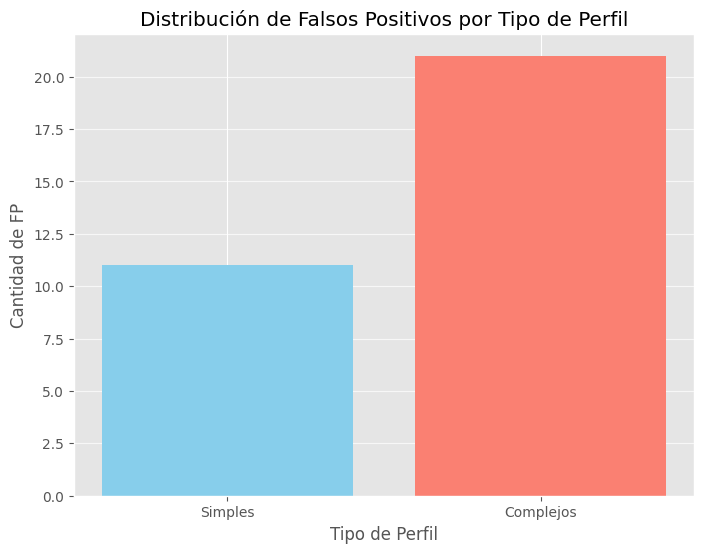

In [28]:
# -- VISUALIZACIÓN --
plt.figure(figsize=(8, 6))
plt.bar(['Simples', 'Complejos'], [fp_simple, fp_complex], color=['skyblue', 'salmon'])
plt.title('Distribución de Falsos Positivos por Tipo de Perfil')
plt.ylabel('Cantidad de FP')
plt.xlabel('Tipo de Perfil')
plt.grid(axis='y', linestyle='-', alpha=0.7)
plt.show()

# PARTE 4

In [29]:
def custom_fp_ratio(y_true, y_pred):
    """
    Métrica que calcula el ratio FP/(TP+FP) para penalizar falsos positivos
    """
    y_pred = (y_pred > 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    ratio = fp / (tp + fp + 1e-7)  # Evitar división por cero
    return 'fp_ratio', ratio, False  # False indica que menor es mejor

Métrica personalizada que mide el ratio de falsos positivos respecto al total de positivos predichos.

    Propósito:
        - Penalizar explícitamente los falsos positivos, es decir, transacciones legítimas marcadas como fraude.
        - Útil para casos donde el costo de un falso positivo es alto (por ejemplo, molestar a clientes buenos).

    Funcionamiento:
        - Convierte predicciones en etiquetas binarias (umbral=0.5).
        - Calcula FP/(TP+FP), que es la proporción de alertas que son realmente falsos positivos.

    Retorno:
        - Una tupla: ('fp_ratio', ratio, False)
        - False indica que valores menores son mejores (menor ratio de FP).

    Parámetros:
        y_true: array-like. Etiquetas verdaderas.
        y_pred: array-like. Probabilidades o predicciones del modelo.

    Ejemplo de uso:
        model.fit(X_train, y_train, eval_metric=custom_fp_ratio)

In [30]:
def balanced_fraud_metric(y_true, y_pred):
    """
    Métrica que combina recall y precisión con énfasis en reducir FPs
    """
    y_pred = (y_pred > 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    precision = tp / (tp + fp + 1e-7)
    recall = tp / (tp + fn + 1e-7)
    
    # Ponderamos más la precisión (para reducir FPs)
    balanced_score = (2 * precision + recall) / 3
    return 'balanced_fraud', balanced_score, True  # True indica que mayor es mejor

Métrica compuesta personalizada para clasificación de fraudes,
    que pondera doble la precisión sobre el recall para priorizar reducción de falsos positivos.

    Propósito:
        - Lograr un balance adecuado entre precisión y recall, pero dando mayor importancia
          a la precisión para evitar falsos positivos en problemas de fraude.

    Funcionamiento:
        - Convierte predicciones en etiquetas binarias (umbral=0.5).
        - Calcula precisión y recall.
        - Calcula un score ponderado: (2 * precisión + recall) / 3

    Retorno:
        - Una tupla: ('balanced_fraud', balanced_score, True)
        - True indica que valores mayores son mejores.

    Parámetros:
        y_true: array-like. Etiquetas verdaderas.
        y_pred: array-like. Probabilidades o predicciones del modelo.

    Ejemplo de uso:
        model.fit(X_train, y_train, eval_metric=balanced_fraud_metric)

In [31]:
def recall_at_90(y_true, y_pred):
    """
    Calcula el recall ajustando el threshold para alcanzar ~90% de detección
    """
    # Encontrar threshold para ~90% recall
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    threshold_idx = np.argmax(recall >= 0.90)
    optimal_threshold = thresholds[threshold_idx]
    
    # Aplicar threshold
    y_pred_adj = (y_pred >= optimal_threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_adj).ravel()
    
    actual_recall = tp / (tp + fn)
    fp_ratio = fp / (tp + fp + 1e-7)
    
    # Score compuesto (max recall manteniendo FP bajo)
    score = actual_recall * (1 - fp_ratio)
    return 'recall90_fp_optimized', score, True

Métrica personalizada que ajusta el threshold para encontrar el punto donde el recall es al menos 90%,
    y penaliza si el ratio de falsos positivos es alto.

    Propósito:
        - Simular un escenario donde se exige que el modelo detecte al menos el 90% de fraudes,
          pero premiando modelos que, en ese threshold, mantengan bajo el ratio de falsos positivos.

    Funcionamiento:
        - Usa la curva Precision-Recall para encontrar el threshold mínimo que da recall >= 0.90.
        - Aplica ese threshold y calcula recall y el ratio de FP/(TP+FP).
        - El score final es recall * (1 - FP ratio): máximo recall, mínimo FP.

    Retorno:
        - Una tupla: ('recall90_fp_optimized', score, True)
        - True indica que valores mayores son mejores.

    Parámetros:
        y_true: array-like. Etiquetas verdaderas.
        y_pred: array-like. Probabilidades o predicciones del modelo.

    Ejemplo de uso:
        model.fit(X_train, y_train, eval_metric=recall_at_90)

In [32]:
# Penalización FP en perfiles complejos
def penalized_fp_complex_metric(y_true, y_pred):
    y_pred = (y_pred > 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    is_complex = test_df['is_complex_profile'].values

    fp_complex = ((y_true == 0) & (y_pred == 1) & (is_complex == 1)).sum()
    fp_total = ((y_true == 0) & (y_pred == 1)).sum()

    penalty = fp_complex / (fp_total + 1e-6)
    recall = tp / (tp + fn + 1e-6)

    score = recall * (1 - penalty)
    return 'fp_complex_penalty', score, True


    Métrica personalizada para LightGBM/Scikit-learn que penaliza los falsos positivos
    específicamente en perfiles de transacción complejos.

    Propósito:
        - En problemas de detección de fraude, los perfiles complejos pueden generar falsos positivos
          (clientes legítimos pero no convencionales) que es importante reducir.
        - Esta métrica evalúa el recall global del modelo, pero penaliza cuando los falsos positivos ocurren
          en este tipo de perfiles.

    Funcionamiento:
        - Calcula la tasa de recall estándar (sensibilidad: TP / (TP + FN)).
        - Calcula el porcentaje de falsos positivos que corresponden a perfiles complejos.
        - Penaliza el recall en función de cuántos falsos positivos afectan a usuarios complejos:
            * Si muchos FP ocurren en perfiles complejos → score disminuye.
            * Si casi no hay FP en complejos → score cercano al recall.

    Retorno:
        - Una tupla: ('fp_complex_penalty', score, True)
        - `score` puede usarse como métrica de optimización personalizada en LightGBM u otros frameworks.

    Parámetros:
        y_true: array-like. Etiquetas verdaderas (0: no fraude, 1: fraude).
        y_pred: array-like. Probabilidades o predicciones del modelo.

    Nota:
        Usa la variable global `test_df['is_complex_profile']` para identificar las transacciones de perfiles complejos.

    Ejemplo de uso:
        model.fit(X_train, y_train, eval_metric=penalized_fp_complex_metric)

In [33]:
# Métrica F0.5 personalizada (precisión > recall)
def fbeta_custom_metric(y_true, y_pred, beta=0.5):
    y_pred = (y_pred > 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)

    fbeta = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-6)
    return f'fbeta_{beta}', fbeta, True


Métrica personalizada F-beta para problemas de clasificación, 
    donde puedes ponderar la importancia relativa de la precisión y el recall.

    Propósito:
        - Calcular el F-beta score, una métrica balanceada que combina precisión y recall,
          pero permitiendo ajustar el peso de cada uno mediante el parámetro beta.
        - En este caso, beta=0.5 da más peso a la precisión (penaliza más los falsos positivos),
          útil en fraudes donde es preferible evitar alarmas innecesarias sobre clientes legítimos.

    Funcionamiento:
        - Convierte las predicciones a etiquetas binarias (umbral=0.5).
        - Calcula precisión (precision) y sensibilidad (recall).
        - Calcula el F-beta score con el beta indicado.

    Retorno:
        - Una tupla: (nombre_metrica, valor, True) donde True indica que mayor es mejor.

    Parámetros:
        y_true: array-like. Etiquetas verdaderas.
        y_pred: array-like. Probabilidades o predicciones del modelo.
        beta: float. Peso relativo entre precisión y recall.

    Ejemplo de uso:
        model.fit(X_train, y_train, eval_metric=lambda yt, yp: fbeta_custom_metric(yt, yp, beta=0.5))

# PARTE 5

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score

# Diccionario para almacenar resultados
results = {}

# Lista de métricas a evaluar
metrics = {
    'fp_ratio': custom_fp_ratio,
    'balanced': balanced_fraud_metric,
    'recall90': recall_at_90,
    'fp_complex_penalty': penalized_fp_complex_metric,
    'fbeta_0.5': lambda y_true, y_pred: fbeta_custom_metric(y_true, y_pred, beta=0.5)

}

# Espacio de búsqueda reducido para métricas custom
custom_param_dist = {
    'num_leaves': randint(20, 80),
    'learning_rate': uniform(0.01, 0.1),
    'min_child_samples': randint(20, 80),
    'scale_pos_weight': [class_ratio, class_ratio*1.5, class_ratio*2]
}

# Entrenar y evaluar cada métrica custom
for metric_name, metric_func in metrics.items():
    print(f"\nOptimizando con métrica: {metric_name}")
    
    model = LGBMClassifier(
        objective='binary',
        n_estimators=1000,
        early_stopping_rounds=20,
        random_state=42,
        device='gpu',
        max_bin=255,
        verbose=-1,
    )
    
    search = RandomizedSearchCV(
        model,
        custom_param_dist,
        n_iter=15,
        scoring='roc_auc',
        cv=TimeSeriesSplit(n_splits=3),
        n_jobs=-1,
        verbose=0,
    )
    
    search.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=metric_func,
        callbacks=[early_stopping(stopping_rounds=20)]
    )
    
    best_model = search.best_estimator_
    y_probs = best_model.predict_proba(X_test)[:, 1]
    y_pred = (y_probs > 0.5).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    fp_ratio = fp / (tp + fp + 1e-7)
    
    results[metric_name] = {
        'model': best_model,
        'recall': recall,
        'precision': precision,
        'fp_ratio': fp_ratio,
        'auc_pr': average_precision_score(y_test, y_probs),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }



Optimizando con métrica: fp_ratio
[824]	valid_0's binary_logloss: 0.00315656
[825]	valid_0's binary_logloss: 0.00315586
[826]	valid_0's binary_logloss: 0.00315495
[827]	valid_0's binary_logloss: 0.00315419
[828]	valid_0's binary_logloss: 0.00315397
[829]	valid_0's binary_logloss: 0.00315246
[830]	valid_0's binary_logloss: 0.0031507
[831]	valid_0's binary_logloss: 0.00314887
[832]	valid_0's binary_logloss: 0.00314517
[833]	valid_0's binary_logloss: 0.0031438
[834]	valid_0's binary_logloss: 0.00314046
[835]	valid_0's binary_logloss: 0.00313934
[836]	valid_0's binary_logloss: 0.00313823
[837]	valid_0's binary_logloss: 0.00313918
[838]	valid_0's binary_logloss: 0.0031384
[839]	valid_0's binary_logloss: 0.00313569
[840]	valid_0's binary_logloss: 0.00313277
[841]	valid_0's binary_logloss: 0.00313182
[842]	valid_0's binary_logloss: 0.00313096
[843]	valid_0's binary_logloss: 0.00312968
[844]	valid_0's binary_logloss: 0.00312891
[845]	valid_0's binary_logloss: 0.00312588
[846]	valid_0's binary

[LightGBM] [Fatal] Check failed: (best_split_info.right_count) > (0) at /home/jsargher/Documents/Security_DS/LightGBM/src/treelearner/serial_tree_learner.cpp, line 663 .



[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
Training until validation scores don't improve for 20 rounds
[335]	valid_0's binary_logloss: 0.00332134
[336]	valid_0's binary_logloss: 0.00332058
[337]	valid_0's binary_logloss: 0.00331918
[338]	valid_0's binary_logloss: 0.00331751
[339]	valid_0's binary_logloss: 0.00331664
[340]	valid_0's binary_logloss: 0.00331449
[341]	valid_0's binary_logloss: 0.00331147
[342]	valid_0's binary_logloss: 0.00331402
[343]	valid_0's binary_logloss: 0.00331064
[344]	valid_0's binary_logloss: 0.00330706
[345]	valid_0's binary_logloss: 0.00330945
[346]	valid_0's binary_logloss: 0.00330721
[347]	valid_0's binary_logloss: 0.00330517
[348]	valid_0's binary_logloss: 0.00330441
[349]	valid_0's binary_logloss: 0.00330364
[350]	valid_0's binary_logloss: 0.00330243
[351]	valid_0's binary_logloss: 0.00330411
[352]	valid_0's binary_logloss: 0.00330056
[353]	valid_0's binary_logloss:


Comparación de Métricas:
                      Recall  Precision  FP Ratio    AUC-PR
fp_ratio            0.883721   0.570000  0.430000  0.869705
balanced            0.918605   0.583744  0.416256  0.899745
recall90            0.949612   0.076348  0.923652  0.199484
fp_complex_penalty  0.953488   0.071595  0.928405  0.401035
fbeta_0.5           0.891473   0.684524  0.315476  0.904808


<Figure size 1200x600 with 0 Axes>

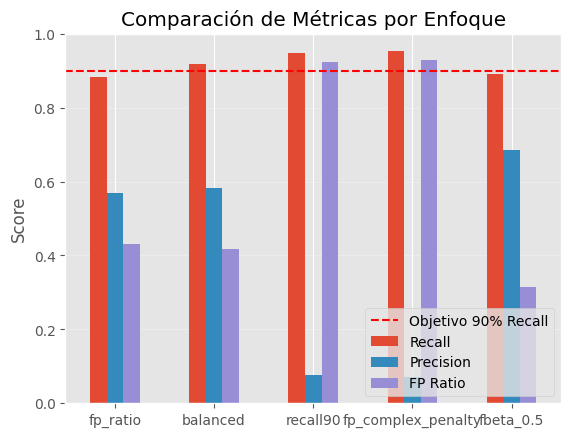

In [35]:
# Crear DataFrame comparativo
# comparison_df = pd.DataFrame.from

comparison_df = pd.DataFrame.from_dict({
    k: {
        'Recall': v.get('recall', np.nan),
        'Precision': v.get('precision', np.nan),
        'FP Ratio': v.get('fp_ratio', np.nan),
        'AUC-PR': v.get('auc_pr', np.nan)
    } for k, v in results.items()
}, orient='index')


print("\nComparación de Métricas:")
print(comparison_df)

# Visualización
plt.figure(figsize=(12, 6))
comparison_df[['Recall', 'Precision', 'FP Ratio']].plot(kind='bar', 
                                                      title='Comparación de Métricas por Enfoque')
plt.axhline(y=0.9, color='r', linestyle='--', label='Objetivo 90% Recall')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y', alpha=0.3)
plt.show()

[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[682]	valid_0's binary_logloss: 0.00302694	valid_0's balanced_fraud: 0.775009
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.239681	valid_0's recall90_fp_optimized: 0.00184896
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
Training until validation scores don't improve for

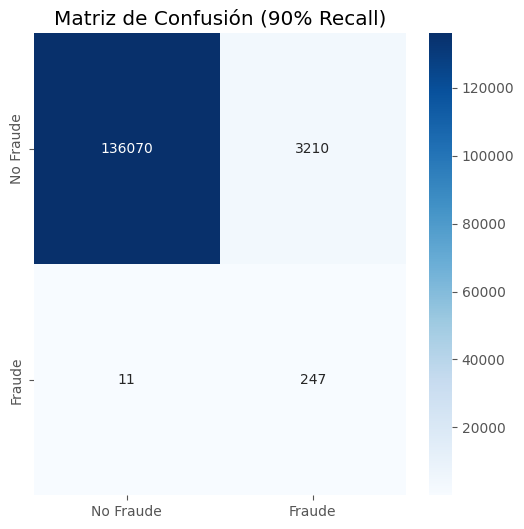

In [36]:
# Seleccionar el mejor modelo para recall
best_recall_model = results['recall90']['model']

def optimize_threshold(model, X, y, target_recall=0.9):
    tscv = TimeSeriesSplit(n_splits=3)
    thresholds = []
    for train_idx, val_idx in tscv.split(X):
        X_train_cv, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train_cv, y_val = y.iloc[train_idx], y.iloc[val_idx]
        # Remueve early_stopping_rounds pero agrega device y max_bin
        params = model.get_params()
        params.pop('early_stopping_rounds', None)
        params['device'] = 'gpu'
        params['max_bin'] = 255
        model_cv = LGBMClassifier(**params)
        model_cv.fit(X_train_cv, y_train_cv)
        y_proba = model_cv.predict_proba(X_val)[:, 1]
        precisions, recalls, threshs = precision_recall_curve(y_val, y_proba)
        optimal_idx = np.argmin(np.abs(recalls - target_recall))
        thresholds.append(threshs[optimal_idx])
    return np.mean(thresholds)


optimal_threshold = optimize_threshold(best_recall_model, X_train, y_train)
print(f"\nThreshold óptimo para 90% recall: {optimal_threshold:.4f}")

# Evaluar con threshold óptimo
y_probs = best_recall_model.predict_proba(X_test)[:, 1]
y_pred_optimal = (y_probs >= optimal_threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_optimal).ravel()

print("\nResultados con Threshold Óptimo (90% Recall):")
print(f"- Threshold usado: {optimal_threshold:.4f}")
print(f"- Recall alcanzado: {tp/(tp+fn):.2%}")
print(f"- FP Ratio: {fp/(tp+fp):.2%}")
print(f"- Precision: {tp/(tp+fp):.2%}")

# Matriz de confusión
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_optimal), 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Fraude', 'Fraude'],
            yticklabels=['No Fraude', 'Fraude'])
plt.title('Matriz de Confusión (90% Recall)')
plt.show()


In [37]:
comparison_df.to_csv("metricas_comparativas.csv", index=True)



Distribución de Falsos Positivos:
Total FP: 3210
FP en perfiles complejos: 1231 (38.35%)
FP en perfiles simples: 1979 (61.65%)


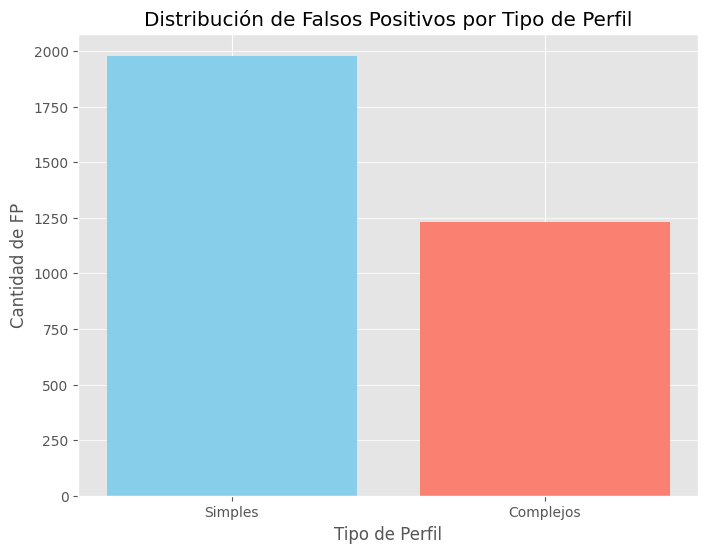

In [38]:
# =============================================
## 6. Análisis de Falsos Positivos por Perfil
## =============================================

test_df['pred_optimal'] = y_pred_optimal
test_df['FP'] = (test_df['is_fraud'] == 0) & (test_df['pred_optimal'] == 1)
test_df['TP'] = (test_df['is_fraud'] == 1) & (test_df['pred_optimal'] == 1)

fp_total = test_df['FP'].sum()
fp_complex = test_df[test_df['is_complex_profile']]['FP'].sum()
fp_simple = test_df[~test_df['is_complex_profile']]['FP'].sum()

print("\nDistribución de Falsos Positivos:")
print(f"Total FP: {fp_total}")
print(f"FP en perfiles complejos: {fp_complex} ({100*fp_complex/fp_total:.2f}%)")
print(f"FP en perfiles simples: {fp_simple} ({100*fp_simple/fp_total:.2f}%)")

# Visualización
plt.figure(figsize=(8, 6))
plt.bar(['Simples', 'Complejos'], [fp_simple, fp_complex], color=['skyblue', 'salmon'])
plt.title('Distribución de Falsos Positivos por Tipo de Perfil')
plt.ylabel('Cantidad de FP')
plt.xlabel('Tipo de Perfil')
plt.grid(axis='y', linestyle='-', alpha=0.7)
plt.show()


Visualización de Matrices de Confusión por Modelo:


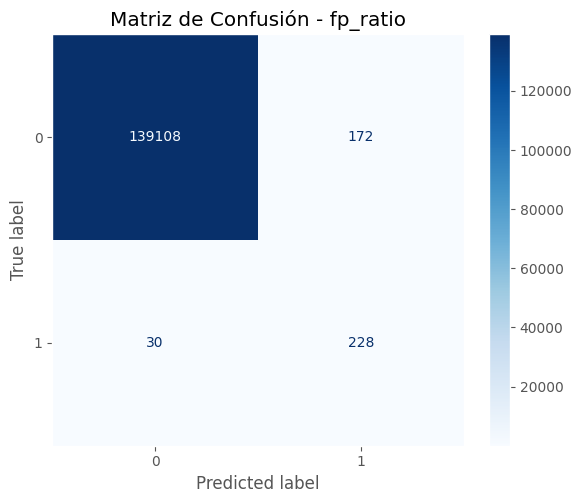

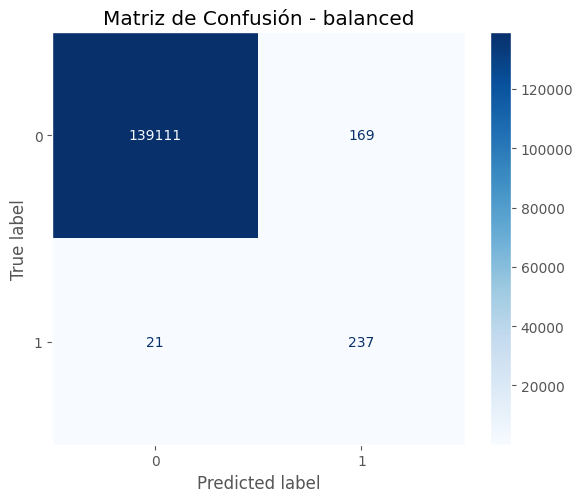

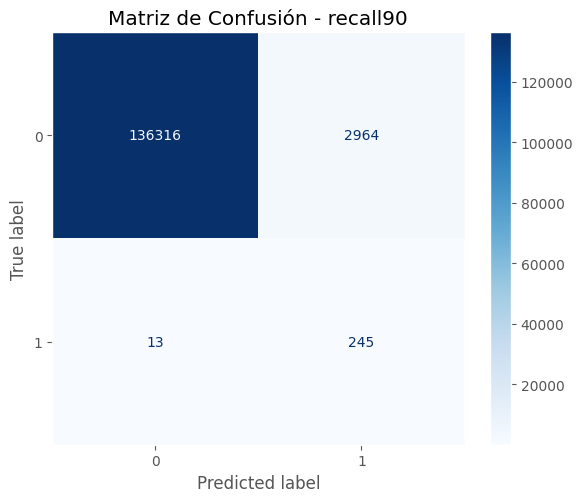

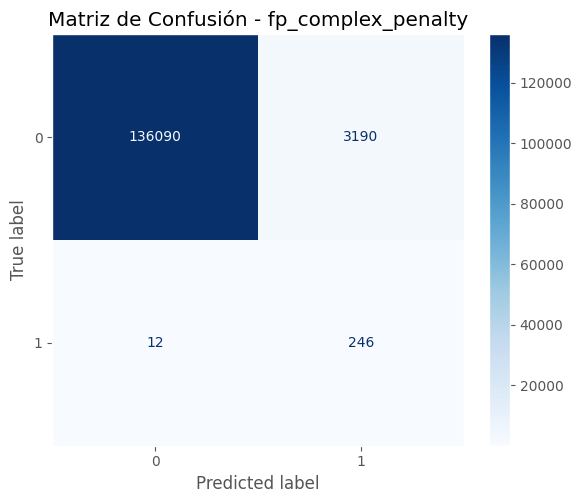

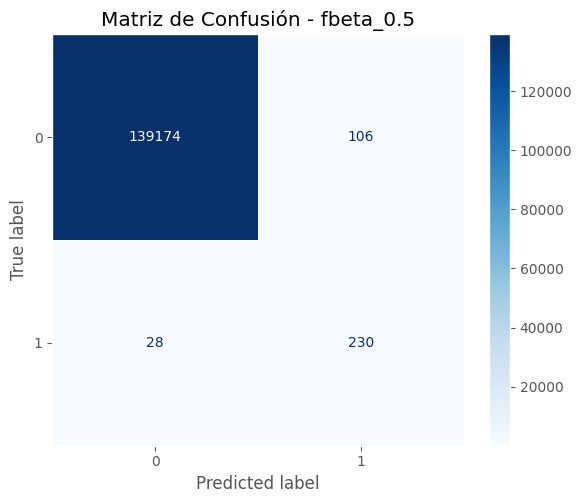

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay

print("\nVisualización de Matrices de Confusión por Modelo:")
for name, result in results.items():
    model = result['model']
    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred = (y_probs > 0.5).astype(int)

    fig, ax = plt.subplots(figsize=(6, 5))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues')
    ax.set_title(f'Matriz de Confusión - {name}')
    plt.grid(False)
    plt.tight_layout()
    plt.show()


In [40]:
def analyze_complex_profile_metrics(y_true, y_pred, name):
    is_complex = test_df['is_complex_profile'].values

    fp_total = ((y_true == 0) & (y_pred == 1)).sum()
    fp_complex = ((y_true == 0) & (y_pred == 1) & (is_complex == 1)).sum()
    fp_simple = fp_total - fp_complex

    print(f"\n{name}:")
    print(f"- Total FP: {fp_total}")
    print(f"- FP complejos: {fp_complex} ({fp_complex/fp_total:.2%})")
    print(f"- FP simples: {fp_simple} ({fp_simple/fp_total:.2%})")


In [41]:
for name, result in results.items():
    y_pred = (result['model'].predict_proba(X_test)[:, 1] > 0.5).astype(int)
    analyze_complex_profile_metrics(y_test, y_pred, name)



fp_ratio:
- Total FP: 172
- FP complejos: 62 (36.05%)
- FP simples: 110 (63.95%)

balanced:
- Total FP: 169
- FP complejos: 68 (40.24%)
- FP simples: 101 (59.76%)

recall90:
- Total FP: 2964
- FP complejos: 1220 (41.16%)
- FP simples: 1744 (58.84%)

fp_complex_penalty:
- Total FP: 3190
- FP complejos: 1115 (34.95%)
- FP simples: 2075 (65.05%)

fbeta_0.5:
- Total FP: 106
- FP complejos: 44 (41.51%)
- FP simples: 62 (58.49%)


In [43]:
# Guardar modelos
for metric_name, result in results.items():
    joblib.dump(result['model'], f"model_{metric_name}.pkl")
    print(f"[✓] Guardado modelo: model_{metric_name}.pkl")

# Guardar solo el threshold de recall90
np.save("threshold_recall90.npy", optimal_threshold)
print("[✓] Guardado threshold: threshold_recall90.npy")


[✓] Guardado modelo: model_fp_ratio.pkl
[✓] Guardado modelo: model_balanced.pkl
[✓] Guardado modelo: model_recall90.pkl
[✓] Guardado modelo: model_fp_complex_penalty.pkl
[✓] Guardado modelo: model_fbeta_0.5.pkl
[✓] Guardado threshold: threshold_recall90.npy


In [ ]:
import lightgbm as lgb
print(lgb.__version__)
clf = lgb.LGBMClassifier(device="gpu")
print("GPU disponible: OK")


In [ ]:
import lightgbm as lgb
print(lgb.__version__)
print(lgb.__file__)
